## 1. Prepare data

In [1]:
from utils.make_txt import make_txt

make_txt(100)

test.txt: 20
val.txt: 25
train.txt: 55


## 2. Train

In [1]:
import os
import itertools
import torch
import torch.nn as nn


from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from utils.misc import str2bool, freeze_net_layers, store_labels

from ssd.ssd import MatchPrior
from ssd.vgg_ssd import create_vgg_ssd
from ssd.config import vgg_ssd_config
from ssd.data_preprocessing import TrainAugmentation, TestTransform

from datasets.COCO_dataset import COCODataset

from nn.multibox_loss import MultiboxLoss

from train_test import train, test

print('Single Shot MultiBox Detector Training With Pytorch')

dataset_type = "COCO"
datasets = "/home/taeho/data/coco2014"
validation_dataset = "/home/taeho/data/coco2014"
net = "vgg16-ssd"

# Params for SGD
lr = 1e-3 #1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
base_net_lr = None
extra_layers_lr = None

# Params for loading pretrained basenet or checkpoints.
base_net = "models/vgg16_reducedfc.pth"
pretrained_ssd = None
resume = "models/vgg16-ssd-Epoch-40-Loss-7.56096.pth"

# Scheduler
scheduler = "multi-step"

# Params for Multi-step Scheduler
milestones = "120,160"

# Params for Cosine Annealing
t_max = 120.0

# Train params
batch_size = 8 #24
num_epochs = 2 #100
num_workers = 4
validation_epochs = 1
debug_steps = 100
use_cuda = True
use_multi_gpu = False
checkpoint_folder = 'models/'
num_training_loss = 0


if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")
    DEVICE_IDS = [1,2] #GPU numbers
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")

    
if net == 'vgg16-ssd':
    create_net = create_vgg_ssd
    config = vgg_ssd_config
else:
    print("No network")
    
    
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)


print("Prepare training and validation datasets.")
datalist = []

if dataset_type == 'COCO':

    dataset = COCODataset(datasets, transform=train_transform,
                         target_transform=target_transform, is_test=False, is_validate=False)
    val_dataset = COCODataset(validation_dataset, transform=test_transform,
                             target_transform=target_transform, is_test=False, is_validate=True)
    
    label_file = os.path.join(checkpoint_folder, "coco-model-labels.txt")
    store_labels(label_file, dataset.class_names)
    num_classes = len(dataset.class_names)
    
    print("Stored labels into file coco-model-labels.txt.")
else:
    print("No dataset_type")


datalist.append(dataset)
train_dataset = ConcatDataset(datalist)

print("Train dataset size: {}". format(len(train_dataset)))
print("validation dataset size: {}".format(len(val_dataset)))

train_loader = DataLoader(train_dataset, batch_size,
                          num_workers=num_workers,
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size,
                        num_workers=num_workers,
                        shuffle=True)


print("Build network.")
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1

base_net_lr = base_net_lr if base_net_lr is not None else lr
extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    
params = [
            {'params': net.base_net.parameters(), 'lr': base_net_lr},
            {'params': itertools.chain(net.source_layer_add_ons.parameters(),
                                       net.extras.parameters()),
             'lr': extra_layers_lr},
            {'params': itertools.chain(net.regression_headers.parameters(),
                                       net.classification_headers.parameters())}
         ]


if resume:
    print("Resume from the model:", resume, "\n")
    net.load(resume)
elif base_net:
    print("Init from base net\n")
    net.init_from_base_net(base_net)
elif pretrained_ssd:
    print("Init from pretrained ssd\n")
    net.init_from_pretrained_ssd(pretrained_ssd)


if use_cuda and use_multi_gpu and torch.cuda.device_count() > 1: # using multi-GPU
    print("Let's use", tuple(DEVICE_IDS), "GPU number.")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    net = nn.DataParallel(net, device_ids=DEVICE_IDS, output_device=DEVICE_IDS[0])
    

net.to(DEVICE) #cuda

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)

print("Learning rate:", lr, "Base net learning rate:", base_net_lr,
      "Extra Layers learning rate:", extra_layers_lr)

if scheduler == 'multi-step':
    print("Uses MultiStepLR scheduler.")
    milestones = [int(v.strip()) for v in milestones.split(",")]
    scheduler = MultiStepLR(optimizer, milestones=milestones,
                            gamma=0.1, last_epoch=last_epoch)
elif scheduler == 'cosine':
    print("Uses CosineAnnealingLR scheduler.")
    scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
else:
    print("Unsupported Scheduler")


print("Start training from epoch 0.\n")
for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)
        
    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        
        print("Epoch:", epoch, "\n", 
              "Validation Loss:", val_loss, "\n",
              "Validation Regression Loss:", val_regression_loss, "\n",
              "Validation Classification Loss:", val_classification_loss
              )
        
        name = "vgg16-ssd" + "-Epoch-" + "%s"%epoch + "-Loss-" + "%s"%str(val_loss)[:7] + ".pth"
        model_path = os.path.join(checkpoint_folder, name)
        net.save(model_path)
        print("Saved model:", model_path, "\n")
        


Single Shot MultiBox Detector Training With Pytorch
Use Cuda.
Prepare training and validation datasets.
Stored labels into file coco-model-labels.txt.
Train dataset size: 55
validation dataset size: 25
Build network.
Resume from the model: models/vgg16-ssd-Epoch-40-Loss-7.56096.pth 

Learning rate: 0.001 Base net learning rate: 0.001 Extra Layers learning rate: 0.001
Uses MultiStepLR scheduler.
Start training from epoch 0.

Epoch: 0 
 Validation Loss: 10.390523910522461 
 Validation Regression Loss: 2.800165355205536 
 Validation Classification Loss: 7.590358734130859
Saved model: models/vgg16-ssd-Epoch-0-Loss-10.3905.pth 

Epoch: 1 
 Validation Loss: 14.131675958633423 
 Validation Regression Loss: 3.6776408553123474 
 Validation Classification Loss: 10.454034924507141
Saved model: models/vgg16-ssd-Epoch-1-Loss-14.1316.pth 



## 3. Eval
__'difficult':__


an object marked as 'difficult', indicates that the object is considered difficult to recognize,  
for example an object which is clearly visible but unidentifiable without substantial use of context.  
Objects marked as difficult are currently ignored in the evaluation of the challenge.

In [1]:
import pathlib
import numpy as np
import torch
import torch.nn as nn


from ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor

from datasets.COCO_dataset import COCODataset

from utils.compute_average_precision_per_class import compute_average_precision_per_class
from utils.group_annotation_by_class import group_annotation_by_class

print("SSD Evaluation on COCO Dataset.")

net = "vgg16-ssd"
trained_model = "models/vgg16-ssd-Epoch-40-Loss-7.56096.pth"
dataset_type = "COCO"
dataset = "/home/taeho/data/coco2014"
label_file = "models/coco-model-labels.txt"
use_cuda = True
use_2007_metric = True # figure out: It computes average precision based on the definition of Pascal Competition.
nms_method = "hard"
iou_threshold = 0.5
eval_dir = "eval_results"


print("Use trained model:", trained_model.split('/')[1])

if use_cuda and torch.cuda.is_available():
    print("Use Cuda.")
    DEVICE_IDS = [1,2]  #GPU numbers
    DEVICE = torch.device("cuda:0")
else:
    DEVICE = torch.device("cpu")
if use_2007_metric:
    print("Computes average precision based on the definition of Pascal Competition.")



if __name__ == '__main__':
    
    eval_path = pathlib.Path(eval_dir)
    eval_path.mkdir(exist_ok=True)
    
    class_names = [name.strip() for name in open(label_file).readlines()]

    if dataset_type == "COCO":
        dataset = COCODataset(dataset, is_test=True)
    else:
        print("No dataset_type")
        
    print("Test dataset size: {}". format(len(dataset)))
    true_case_stat, all_gb_boxes, all_difficult_cases = group_annotation_by_class(dataset)
    
    if net == 'vgg16-ssd':
        net = create_vgg_ssd(len(class_names), is_test=True)
        predictor = create_vgg_ssd_predictor(net, nms_method=nms_method, device=DEVICE)
    else:
        print("No net type")

    print("Load Model")
    net.load(trained_model)
    
    if use_cuda and torch.cuda.device_count() > 1: # using multi-GPU
        print("Let's use", tuple(DEVICE_IDS), "GPU number.")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        net = nn.DataParallel(net, device_ids=DEVICE_IDS, output_device=DEVICE_IDS[0])
    
    net = net.to(DEVICE)
    
    
    results = []
    for i in range(len(dataset)):
        if i == 0:
            print("process image", i, "start")
        if i % 100 == 0 and i != 0:
            print("process image", i)
        if i == (len(dataset)-1):
            print("process image", i, "end")
            
        image = dataset.get_image(i)
        boxes, labels, probs = predictor.predict(image)
        indexes = torch.ones(labels.size(0), 1, dtype=torch.float32) * i
        results.append(torch.cat([indexes.reshape(-1, 1),
                                  labels.reshape(-1, 1).float(),
                                  probs.reshape(-1, 1),
                                  boxes + 0.0  # matlab's indexes start from 1
                                 ], dim=1))
        
    results = torch.cat(results)
    
    aps = []
    print("\nAverage Precision Per-class:\n")
    for class_index, class_name in enumerate(class_names):
        if class_index == 0:
            continue  # ignore background
            
        prediction_path = eval_path / f"det_test_{class_name}.txt"
        
        with open(prediction_path, "w") as f:
            sub = results[results[:, 1] == class_index, :]
            for i in range(sub.size(0)):
                prob_box = sub[i, 2:].numpy()
                image_id = dataset.ids[int(sub[i, 0])]
                print(image_id + " " + " ".join([str(v) for v in prob_box]), file=f)
        
        try:
            ap = compute_average_precision_per_class(true_case_stat[class_index],
                                                     all_gb_boxes[class_index],
                                                     all_difficult_cases[class_index],
                                                     prediction_path,
                                                     iou_threshold,
                                                     use_2007_metric)
        except KeyError:
            pass
        
        aps.append(ap)
        if ap > 1e-7: #exclude 0.0 ap
            print(f"{class_name}: {ap}")
    
    print(f"\nAverage Precision Across All Classes:{sum(aps)/len(aps)}")
    

SSD Evaluation on COCO Dataset.
Use trained model: vgg16-ssd-Epoch-40-Loss-7.56096.pth
Use Cuda.
Computes average precision based on the definition of Pascal Competition.
Test dataset size: 20


/home/taeho/문서/coco-ssd/utils/group_annotation_by_class.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_gt_boxes[class_index][image_id] = torch.tensor(all_gt_boxes[class_index][image_id])


Load Model
process image 0 start
process image 19 end

Average Precision Per-class:

person: 0.2577762299811989
train: 0.030303030303030304
truck: 0.030303030303030304
boat: 0.030303030303030304
traffic light: 0.030303030303030304
fire hydrant: 0.030303030303030304
cow: 0.03636363636363637
elephant: 0.03636363636363637
bear: 0.03636363636363637
zebra: 0.03636363636363637
giraffe: 0.03636363636363637
skateboard: 0.07142857142857144
surfboard: 0.07142857142857144
tennis racket: 0.07142857142857144
bottle: 0.050228586233627616
cup: 7.918910357934748e-05
bowl: 0.018842295188422953
banana: 0.018842295188422953
chair: 0.0036363636363636364
couch: 0.0036363636363636364
potted plant: 0.0013908205841446453
bed: 0.0013908205841446453
dining table: 0.05954444668413627
toilet: 0.025000000000000005
oven: 0.045454545454545456
sink: 0.009816386821734415
refrigerator: 0.027972027972027972

Average Precision Across All Classes:0.013390367733597


In [1]:
# sort dictionary by key
d = {2:3, 1:89, 4:5, 3:0}
dict(sorted(d.items(), reverse=True))

{4: 5, 3: 0, 2: 3, 1: 89}

## 4. Visualize

Use model: models/vgg16-ssd-Epoch-40-Loss-7.56096.pth 

Image name: COCO_val2014_000000391895
We find 0 objects,
but actually there are 4 objects.


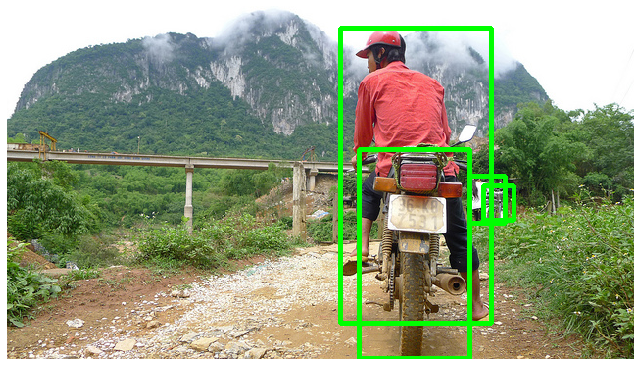

Image name: COCO_val2014_000000184613
We find 0 objects,
but actually there are 24 objects.


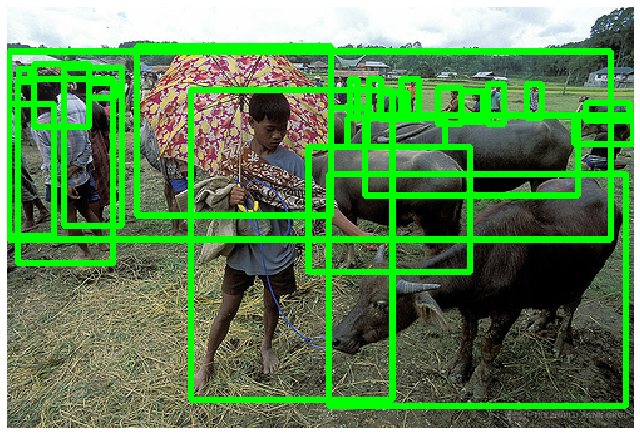

Image name: COCO_val2014_000000309022
We find 0 objects,
but actually there are 8 objects.


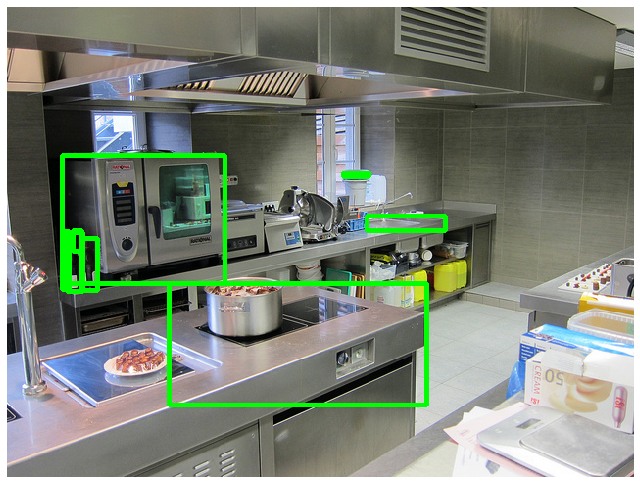

Image name: COCO_val2014_000000060623
We find 0 objects,
but actually there are 7 objects.


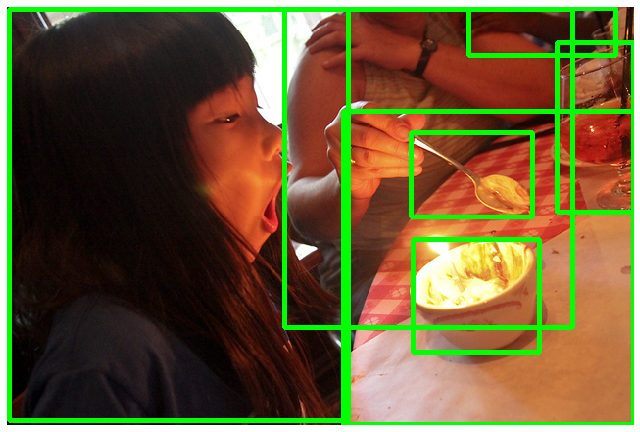

Image name: COCO_val2014_000000374628
We find 0 objects,
but actually there are 25 objects.


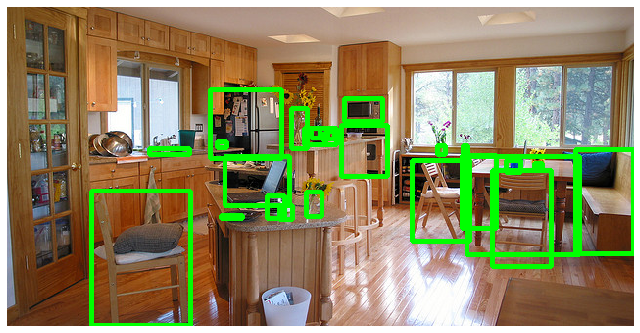

Image name: COCO_val2014_000000328757
We find 1 objects,
but actually there are 7 objects.


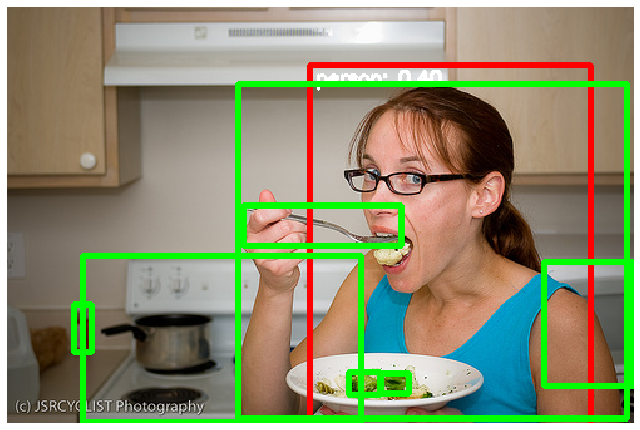

Image name: COCO_val2014_000000293802
We find 1 objects,
but actually there are 23 objects.


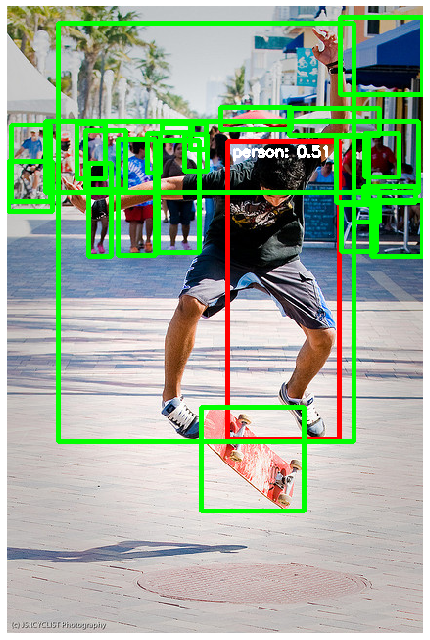

Image name: COCO_val2014_000000574769
We find 0 objects,
but actually there are 19 objects.


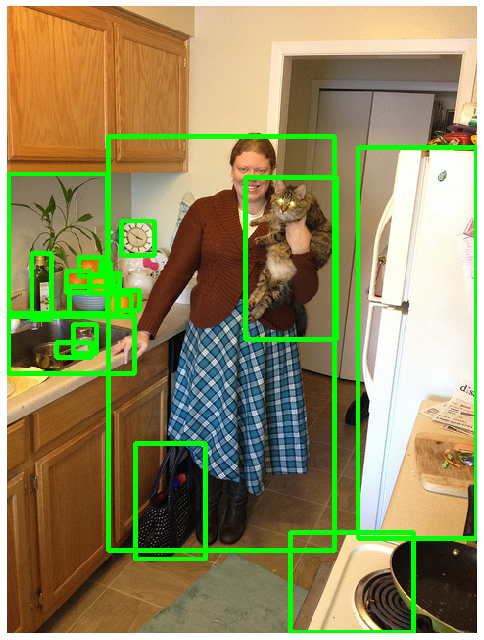

Image name: COCO_val2014_000000384213
We find 0 objects,
but actually there are 10 objects.


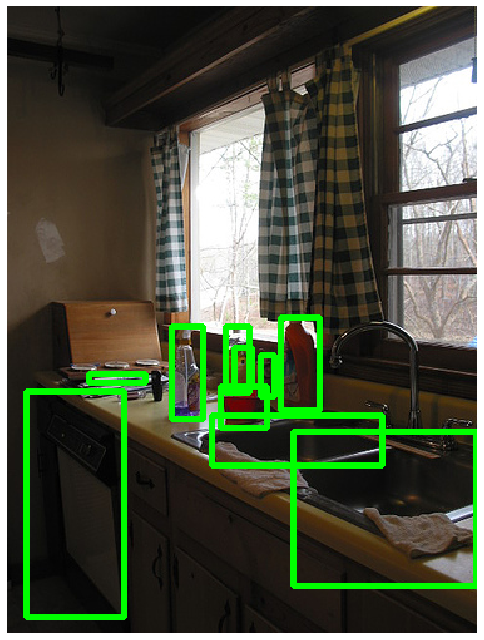

Image name: COCO_val2014_000000318219
We find 0 objects,
but actually there are 11 objects.


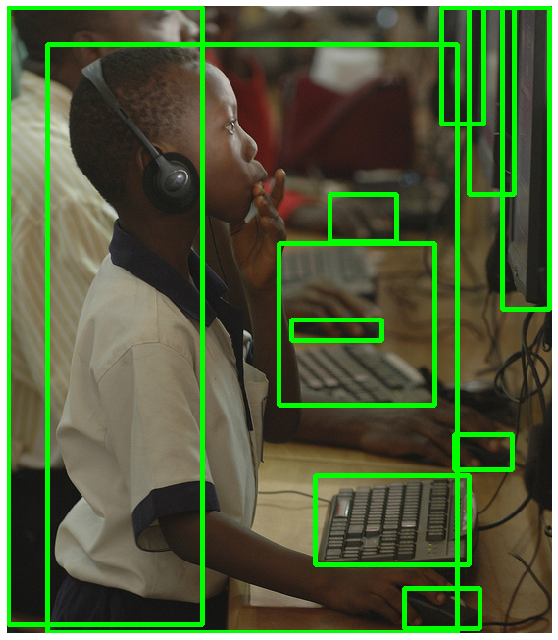

In [1]:
from utils.image_print import image_print

%matplotlib inline


net_type = "vgg16-ssd"
model_path = "models/vgg16-ssd-Epoch-40-Loss-7.56096.pth"
label_path = "models/coco-model-labels.txt"
data_dir = "/home/taeho/data/coco2014/"
test_txt = "/home/taeho/data/coco2014/images/test.txt"
how_many_images = 10

print("Use model:", model_path, "\n")
image_print(net_type=net_type,
            model_path=model_path,
            label_path=label_path,
            data_dir=data_dir,
            test_txt=test_txt,
            how_many_images=how_many_images)